In [492]:
from urllib.request import Request, urlopen
import pandas as pd
import re
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from urllib.parse import unquote
from time import sleep, time

%matplotlib inline

In [389]:
state_acronym_str = """Alabama - AL
Alaska - AK
Arizona - AZ
Arkansas - AR
California - CA
Colorado - CO
Connecticut - CT
Delaware - DE
Florida - FL
Georgia - GA
Hawaii - HI
Idaho - ID
Illinois - IL
Indiana - IN
Iowa - IA
Kansas - KS
Kentucky - KY
Louisiana - LA
Maine - ME
Maryland - MD
Massachusetts - MA
Michigan - MI
Minnesota - MN
Mississippi - MS
Missouri - MO
Montana - MT
Nebraska - NE
Nevada - NV
New Hampshire - NH
New Jersey - NJ
New Mexico - NM
New York - NY
North Carolina - NC
North Dakota - ND
Ohio - OH
Oklahoma - OK
Oregon - OR
Pennsylvania - PA
Rhode Island - RI
South Carolina - SC
South Dakota - SD
Tennessee - TN
Texas - TX
Utah - UT
Vermont - VT
Virginia - VA
Washington - WA
West Virginia - WV
Wisconsin - WI
Wyoming - WY"""
state_acronyms = {
    line.split(' - ')[0]: line.split(' - ')[1]
    for line in state_acronym_str.split('\n')
}

party_acronyms = {
    'Republican': 'R',
    'Democratic': 'D',
    'Independent': 'I',
    'Independent Democrat': 'D', # just Joe Lieberman
}

candidates = [
    'Sen. Sanders, Bernard',
    'Sen. Warren, Elizabeth',
    'Sen. Klobuchar, Amy',
    'Sen. Biden, Joseph R., Jr.',
    'Sen. Bennet, Michael F.',
    'Sen. Booker, Cory A.',
    'Sen. Harris, Kamala D.',
    'Sen. Gillibrand, Kirsten E.',
    'Sen. Gravel, Mike',
    'Sen. Clinton, Hillary Rodham'
]

In [536]:
bill_files = [
    'senate_bills_law_109_116.csv',
    'senate_bills_law_103_108.csv',
    'senate_bills_law_100_102.csv',
    'senate_bills_law_97_99.csv',
    'senate_bills_law_94_96.csv',
    'senate_bills_law_93.csv',
]

def choose_party(row):
    name = row.get('Sponsor') or row['Name']
    party_initial = row.get('Party Acronym') or re.search(r'\[(\w{1,2})-\w{2}\]', name).groups(0)[0]
    if party_initial == 'D':
        return 'Democratic'
    elif party_initial == 'ID':
        return 'Democratic'
    elif party_initial == 'R':
        return 'Republican'
    # handle by caucusing https://www.congress.gov/member/harry-byrd/B001209?q={%22search%22:[%22Independent%22]}&s=9&r=7&searchResultViewType=expanded&KWICView=false
    elif 'Sanders' in name or 'King' in name or 'Lieberman' in name or 'Jeffords' in name:
        return 'Democratic'
    elif 'Smith, Bob' in name:
        return 'Republican'
    elif 'Sen. Byrd, Harry F., Jr. [I-VA]' == name:
        return 'Democratic'
    # should only include Dean Barkley
    else:
        return 'Independent'

all_bills = pd.concat([pd.read_csv(file, skiprows=3) for file in bill_files]).reset_index()
all_bills['Congress'] = all_bills['Congress'].map(lambda s: s if s[0] == '1' else ' '+s)
all_bills['Congress Number'] = all_bills['Congress'].map(lambda s: int(re.sub(r'[a-z]', '', s.split()[0])))
all_bills['Name Bill'] = all_bills['Title'].map(lambda t: 'designate' in t.lower().split())
all_bills['Type'] = all_bills['Legislation Number'].map(lambda n: n.split()[0])
all_bills['Number'] = all_bills['Legislation Number'].map(lambda n: int(n.split()[1]))
all_bills['Sponsor Name'] = all_bills['Sponsor'].map(lambda s: re.sub(' \[[\w\-]+\]', '', s))
all_bills['Party'] = all_bills.apply(choose_party, axis=1)
all_bills = all_bills[['Congress', 'Congress Number', 'Legislation Number', 'Type', 'Number', 'Title', 'Sponsor Name', 'Party', 'Number of Cosponsors', 'Name Bill', 'Latest Action Date', 'URL']]
all_bills

,Congress,Congress Number,Legislation Number,Type,Number,Title,Sponsor Name,Party,Number of Cosponsors,Name Bill,Latest Action Date,URL
0,116th Congress (2019-2020),116,S. 3201,S.,3201,Temporary Reauthorization and Study of the Eme...,"Sen. Graham, Lindsey",Republican,6,False,02/06/2020,https://www.congress.gov/bill/116th-congress/s...
1,116th Congress (2019-2020),116,S. 2710,S.,2710,A bill to prohibit the commercial export of co...,"Sen. Merkley, Jeff",Democratic,17,False,11/27/2019,https://www.congress.gov/bill/116th-congress/s...
2,116th Congress (2019-2020),116,S. 2249,S.,2249,A bill to allow the Deputy Administrator of th...,"Sen. Wicker, Roger F.",Republican,0,False,08/02/2019,https://www.congress.gov/bill/116th-congress/s...
3,116th Congress (2019-2020),116,S. 2047,S.,2047,A bill to provide for a 2-week extension of th...,"Sen. Schumer, Charles E.",Democratic,0,False,07/05/2019,https://www.congress.gov/bill/116th-congress/s...
4,116th Congress (2019-2020),116,S. 1838,S.,1838,Hong Kong Human Rights and Democracy Act of 2019,"Sen. Rubio, Marco",Republican,56,False,11/27/2019,https://www.congress.gov/bill/116th-congress/s...
5,116th Congress (2019-2020),116,S. 1790,S.,1790,National Defense Authorization Act \nfor Fisca...,"Sen. Inhofe, James M.",Republican,0,False,12/20/2019,https://www.congress.gov/bill/116th-congress/s...
6,116th Congress (2019-2020),116,S. 1749,S.,1749,Protecting Affordable Mortgages for Veterans A...,"Sen. Sinema, Kyrsten",Democratic,1,False,07/25/2019,https://www.congress.gov/bill/116th-congress/s...
7,116th Congress (2019-2020),116,S. 1693,S.,1693,National Flood Insurance Program Extension Act...,"Sen. Kennedy, John",Republican,0,False,05/31/2019,https://www.congress.gov/bill/116th-congress/s...
8,116th Congress (2019-2020),116,S. 1689,S.,1689,A bill to permit States to transfer certain fu...,"Sen. Booker, Cory A.",Democratic,1,False,10/04/2019,https://www.congress.gov/bill/116th-congress/s...
9,116th Congress (2019-2020),116,S. 1436,S.,1436,A bill to make technical corrections to the co...,"Sen. Brown, Sherrod",Democratic,2,False,06/12/2019,https://www.congress.gov/bill/116th-congress/s...


In [509]:
congress_map = all_bills[['Congress', 'Congress Number']].drop_duplicates()
congress_map

,Congress,Congress Number
0,116th Congress (2019-2020),116
33,115th Congress (2017-2018),115
174,114th Congress (2015-2016),114
284,113th Congress (2013-2014),113
361,112th Congress (2011-2012),112
440,111th Congress (2009-2010),111
560,110th Congress (2007-2008),110
702,109th Congress (2005-2006),109
853,108th Congress (2003-2004),108
1001,107th Congress (2001-2002),107


In [213]:
len(all_bills)

4321

In [537]:
def get_cosponsors(url):
    request = Request(url + '/cosponsors', headers={'User-Agent': 'Mozilla/5.0'})
    try:
        with urlopen(request) as response:
            html = response.read()
    except:
        sleep(3)
        print("Got error, sleeping for 3 seconds")
        with urlopen(request) as response:
            html = response.read()
    soup = BeautifulSoup(html, 'html.parser')
    return [
        sen.get_text().strip('*')
        for table in soup.find_all(attrs={"class": "item_table"})
        for sen in table.find_all('a')
    ]    

def generate_sponsors(df, sleep_secs = 0, limit=10000, notify_every=100, file_name='cosponsors.csv'):
    sponsors = df\
        .iloc[0:limit][['URL', 'Congress Number', 'Legislation Number', 'Name Bill', 'Number of Cosponsors', 'Sponsor']]\
        .copy()\
        .reset_index()
    sponsors['Cosponsor'] = False
    new_rows = []
    start_time = time()
    sponsors.drop('URL', axis=1)\
        .sort_values(['Congress Number', 'Legislation Number', 'Cosponsor', 'Sponsor'], ascending=False)\
        .to_csv(file_name, index=False)
    for (i, row) in sponsors.iterrows():
        cosponsors = get_cosponsors(row['URL'])
        for cosponsor in cosponsors:
            new_rows.append((
                row['Congress Number'],
                row['Legislation Number'],
                row['Name Bill'],
                row['Number of Cosponsors'],
                cosponsor,
                True
            ))
        sleep(sleep_secs)
        if (i % notify_every == 0 and i > 0) or (i == len(sponsors) -1):
            print('Processed {0} bills in {1} seconds'.format(i, time() - start_time))
            new_sponsors =  pd.DataFrame(new_rows, columns=['Congress Number', 'Legislation Number', 'Name Bill', 'Number of Cosponsors', 'Sponsor', 'Cosponsor'])
            new_rows=[]
            with open(file_name, 'a') as file:
                new_sponsors.to_csv(file, header=False, index=False)
    sponsors = pd.read_csv(file_name)\
        .sort_values(['Congress Number', 'Legislation Number', 'Cosponsor', 'Sponsor'], ascending=False)
    sponsors.to_csv(file_name)
    return sponsors
sponsors = generate_sponsors(all_bills)

KeyError: "['Sponsor'] not in index"

In [522]:
sponsors = pd.read_csv('cosponsors_fixed.csv', index_col=False)
sponsors['Sponsor Name'] = sponsors['Sponsor'].map(lambda s: re.sub(' \[[\w\-]+\]', '', s))
sponsors['Party'] = sponsors.apply(choose_party, axis=1)
sponsors = sponsors.drop('Sponsor', axis=1)

In [523]:
def sponsor_score(row):
    if not row['Cosponsor']:
        return 1.0 if row['Number of Cosponsors'] == 0 else 0.5
    else:
        return 0.5 / row['Number of Cosponsors']
sponsors['Weighted Score'] = sponsors.apply(sponsor_score, axis=1)
sponsors['Sponsored Count'] = sponsors['Cosponsor'].apply(lambda s: 0 if s else 1)
sponsors['Cosponsored Count'] = sponsors['Cosponsor'].apply(lambda s: 1 if s else 0)
sponsors

,Congress Number,Legislation Number,Name Bill,Number of Cosponsors,Cosponsor,Sponsor Name,Party,Weighted Score,Sponsored Count,Cosponsored Count
0,103,S.J.Res. 99,False,72,True,"Sen. D'Amato, Alfonse",Republican,0.006944,0,1
1,103,S.J.Res. 99,False,72,True,"Sen. Biden, Joseph R., Jr.",Democratic,0.006944,0,1
2,103,S.J.Res. 99,False,72,True,"Sen. Bradley, Bill",Democratic,0.006944,0,1
3,103,S.J.Res. 99,False,72,True,"Sen. Graham, Bob",Democratic,0.006944,0,1
4,103,S.J.Res. 99,False,72,True,"Sen. Heflin, Howell",Democratic,0.006944,0,1
5,103,S.J.Res. 99,False,72,True,"Sen. Hollings, Ernest F.",Democratic,0.006944,0,1
6,103,S.J.Res. 99,False,72,True,"Sen. Inouye, Daniel K.",Democratic,0.006944,0,1
7,103,S.J.Res. 99,False,72,True,"Sen. Johnston, J. Bennett",Democratic,0.006944,0,1
8,103,S.J.Res. 99,False,72,True,"Sen. Lautenberg, Frank R.",Democratic,0.006944,0,1
9,103,S.J.Res. 99,False,72,True,"Sen. Mitchell, George J.",Democratic,0.006944,0,1


In [568]:
def print_table(df):
    print('| ' + ' | '.join(df.reset_index().columns) + ' |')
    print('|' + '|'.join(['-------' for i in df.reset_index().columns]) + '|')
    for (i, row) in df.reset_index().iterrows():
        print('| ' + ' | '.join([str(x) for x in row]) + ' |')


In [569]:
candidates_raw = sponsors.loc[~sponsors['Name Bill']]\
    .groupby('Sponsor Name')[['Sponsored Count', 'Cosponsored Count']]\
    .sum()\
    .loc[candidates].sort_values(['Sponsored Count'], ascending=False)

print_table(candidates_raw)

| Sponsor Name | Sponsored Count | Cosponsored Count |
|-------|-------|-------|
| Sen. Biden, Joseph R., Jr. | 23 | 223 |
| Sen. Klobuchar, Amy | 12 | 119 |
| Sen. Gravel, Mike | 10 | 58 |
| Sen. Booker, Cory A. | 2 | 39 |
| Sen. Sanders, Bernard | 1 | 48 |
| Sen. Warren, Elizabeth | 1 | 50 |
| Sen. Bennet, Michael F. | 1 | 51 |
| Sen. Clinton, Hillary Rodham | 1 | 71 |
| Sen. Harris, Kamala D. | 0 | 16 |
| Sen. Gillibrand, Kirsten E. | 0 | 67 |


In [563]:
next(candidates_raw.iterrows())[1]

Sponsored Count       23
Cosponsored Count    223
Name: Sen. Biden, Joseph R., Jr., dtype: int64

In [525]:
bills_parties = sponsors[['Congress Number', 'Legislation Number', 'Party']].copy()
bills_parties['Party Count'] = sponsors['Party']
bills_parties = bills_parties\
    .groupby(['Congress Number', 'Legislation Number'])\
    .agg({'Party': 'max', 'Party Count': 'nunique'})
    #.reset_index()
def choose_bipartisan(row):
    if row['Party Count'] > 1:
        return 'Bipartisan'
    else:
        return row['Party']

all_bills = all_bills.drop(['Party'], axis=1).join(bills_parties, on=['Congress Number', 'Legislation Number'], how='left')
all_bills['Party'] = all_bills.apply(choose_bipartisan, axis=1)
all_bills.head()

,Congress,Congress Number,Legislation Number,Type,Number,Title,Sponsor Name,Number of Cosponsors,Name Bill,Latest Action Date,URL,Party,Party Count
0,116th Congress (2019-2020),116,S. 3201,S.,3201,Temporary Reauthorization and Study of the Eme...,"Sen. Graham, Lindsey",6,False,02/06/2020,https://www.congress.gov/bill/116th-congress/s...,Bipartisan,2
1,116th Congress (2019-2020),116,S. 2710,S.,2710,A bill to prohibit the commercial export of co...,"Sen. Merkley, Jeff",17,False,11/27/2019,https://www.congress.gov/bill/116th-congress/s...,Bipartisan,2
2,116th Congress (2019-2020),116,S. 2249,S.,2249,A bill to allow the Deputy Administrator of th...,"Sen. Wicker, Roger F.",0,False,08/02/2019,https://www.congress.gov/bill/116th-congress/s...,Republican,1
3,116th Congress (2019-2020),116,S. 2047,S.,2047,A bill to provide for a 2-week extension of th...,"Sen. Schumer, Charles E.",0,False,07/05/2019,https://www.congress.gov/bill/116th-congress/s...,Democratic,1
4,116th Congress (2019-2020),116,S. 1838,S.,1838,Hong Kong Human Rights and Democracy Act of 2019,"Sen. Rubio, Marco",56,False,11/27/2019,https://www.congress.gov/bill/116th-congress/s...,Bipartisan,2


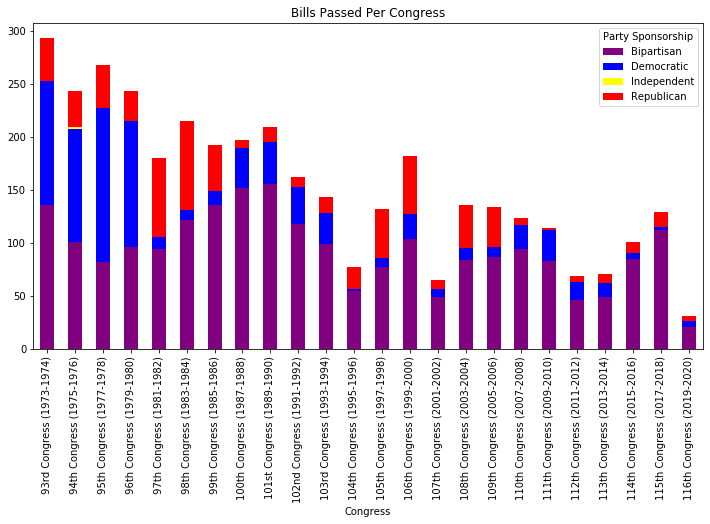

In [526]:
all_bills.loc[~all_bills['Name Bill']]\
    .rename(columns={'Party': 'Party Sponsorship'})\
    .pivot_table(values='Number', index='Congress', columns='Party Sponsorship', aggfunc=pd.Series.nunique)\
    .plot.bar(stacked=True, color=['purple', 'blue', 'yellow', 'red'], title='Bills Passed Per Congress', figsize=(12,6))
plt.show()

In [527]:
(2020 - 1788) // 2

116

In [539]:
senators = pd.read_csv('senators.csv', skiprows=3)
def whole_name_func(row):
    return row['Name'].replace('Senator', 'Sen.')
senators['Name'] = senators.apply(whole_name_func, axis=1)

def to_congress(year):
    if year == 'Present':
        year = 2020
    return (int(year) - 1788) // 2

def get_congresses(terms):
    senate_terms = terms.split(' | ')[0]
    matches = [
        c
        for match in re.findall(r'\d{4}-(?:\d{4}|Present)', senate_terms)
        for c in range(to_congress(match.split('-')[0])+1, to_congress(match.split('-')[1]) + 1)
    ]
    return matches
senators['Congresses']  = senators['Terms'].map(get_congresses)
senators = senators.drop('District', axis=1)
senators['Current'] = senators['Congresses'].map(lambda cs: 116 in cs)
senators['Party Acronym'] = senators['Party'].map(party_acronyms)
senators['Party'] = senators.apply(choose_party, axis = 1)
senators = senators.drop('Party Acronym', axis=1)

In [540]:
rows = []
for (i, row) in senators[['Name', 'Congresses', 'Party']].iterrows():
    for congress in row['Congresses']:
        rows.append((row['Name'], row['Party'], congress))
senators_by_congress = pd.DataFrame(rows, columns=['Sponsor Name', 'Party', 'Congress Number'])
senator_score_by_congress = sponsors.loc[~sponsors['Name Bill']]\
    .groupby(['Sponsor Name', 'Congress Number'])[['Sponsored Count', 'Cosponsored Count', 'Weighted Score']].sum()

senator_score_by_congress = senators_by_congress\
    .loc[senators_by_congress['Congress Number'] >= 93]\
    .join(senator_score_by_congress, on=['Sponsor Name', 'Congress Number'], how='left')\
    .fillna(0.0)\

score_by_congress = senator_score_by_congress\
    .groupby(['Party', 'Congress Number'])[['Weighted Score']]\
    .mean()

senators_scores = senator_score_by_congress\
    .join(
        score_by_congress.rename(columns={'Weighted Score': 'Typical Weighted Score'}),
        on=['Party', 'Congress Number'],
        how='left',
    )\
    .groupby('Sponsor Name')[['Sponsored Count', 'Cosponsored Count', 'Weighted Score', 'Typical Weighted Score']].sum()
senators_scores['Score Relative to Expectation'] = senators_scores['Weighted Score'] / senators_scores['Typical Weighted Score']
senators_scores = senators_scores.sort_values(['Score Relative to Expectation'], ascending=False)
senators_scores['Rank'] = pd.RangeIndex(0, len(senators_scores)) + 1
senators_scores = senators_scores.join(
    senators[['Name', 'Party', 'Current']].rename({'Name': 'Sponsor Name'}, axis=1).set_index('Sponsor Name'),
    on=['Sponsor Name'],
    how='left',
)
senators_scores = senators_scores[['Party', 'Current', 'Sponsored Count', 'Cosponsored Count', 'Weighted Score', 'Score Relative to Expectation', 'Rank']]
senators_scores.loc[candidates].sort_values(['Score Relative to Expectation'], ascending=False)

,Party,Current,Sponsored Count,Cosponsored Count,Weighted Score,Score Relative to Expectation,Rank
Sponsor Name,,,,,,,
"Sen. Klobuchar, Amy",Democratic,True,12.0,119.0,10.025688,1.428373,60
"Sen. Gravel, Mike",Democratic,False,10.0,58.0,12.295537,1.001053,128
"Sen. Clinton, Hillary Rodham",Democratic,False,1.0,70.0,3.980090,0.966699,135
"Sen. Booker, Cory A.",Democratic,True,2.0,39.0,2.355690,0.744204,213
"Sen. Warren, Elizabeth",Democratic,True,1.0,50.0,2.317983,0.732291,216
"Sen. Biden, Joseph R., Jr.",Democratic,False,23.0,223.0,21.891316,0.700585,222
"Sen. Bennet, Michael F.",Democratic,True,1.0,51.0,2.376741,0.437931,307
"Sen. Gillibrand, Kirsten E.",Democratic,True,0.0,67.0,1.627125,0.299809,346
"Sen. Sanders, Bernard",Democratic,True,1.0,48.0,2.031032,0.289364,351


In [541]:
senators_scores.loc[senators_scores['Current']]

,Party,Current,Sponsored Count,Cosponsored Count,Weighted Score,Score Relative to Expectation,Rank
Sponsor Name,,,,,,,
"Sen. Sinema, Kyrsten",Democratic,True,2.0,4.0,1.090981,3.335135,2
"Sen. Kennedy, John",Republican,True,6.0,34.0,4.342216,2.460335,10
"Sen. Hawley, Josh",Republican,True,1.0,5.0,0.695147,2.317604,12
"Sen. Sullivan, Dan",Republican,True,6.0,30.0,5.644062,2.044248,19
"Sen. Rosen, Jacky",Democratic,True,1.0,6.0,0.629292,1.923751,23
"Sen. Feinstein, Dianne",Democratic,True,28.0,187.0,25.657844,1.851680,26
"Sen. Leahy, Patrick J.",Democratic,True,74.0,355.0,61.192702,1.850854,27
"Sen. Johnson, Ron",Republican,True,8.0,27.0,6.992071,1.783612,30
"Sen. Rubio, Marco",Republican,True,7.0,61.0,6.772221,1.727530,32


In [542]:
score_by_congress

Weighted Score
Party       Congress Number                
Democratic  93                     3.612522
            94                     2.687365
            95                     2.945318
            96                     3.037400
            97                     1.075787
            98                     1.327872
            99                     1.398919
            100                    2.402317
            101                    2.457414
            102                    1.872956
            103                    1.599873
            104                    0.482446
            105                    0.874905
            106                    1.354892
            107                    0.587183
            108                    0.947668
            109                    0.990600
            110                    1.591748
            111                    1.415273
            112                    0.846553
            113                    0.766144
            114                    1.048424
            115                    1.023699
            116                    0.327117
Independent 93                     0.507576
            94                     1.500000
            95                     0.052394
            96                     0.036301
            97                     0.331188
Republican  93                     2.013152
            94                     1.904295
            95                     1.659787
            96                     1.447495
            97                     2.436090
            98                     2.881296
            99                     2.394128
            100                    1.432203
            101                    1.603103
            102                    1.151111
            103                    1.200339
            104                    1.015343
            105                    1.715117
            106                    2.200293
            107                    0.707635
            108                    1.772332
            109                    1.636329
            110                    0.844441
            111                    0.706840
            112                    0.518620
            113                    0.640609
            114                    0.996059
            115                    1.464946
            116                    0.299942

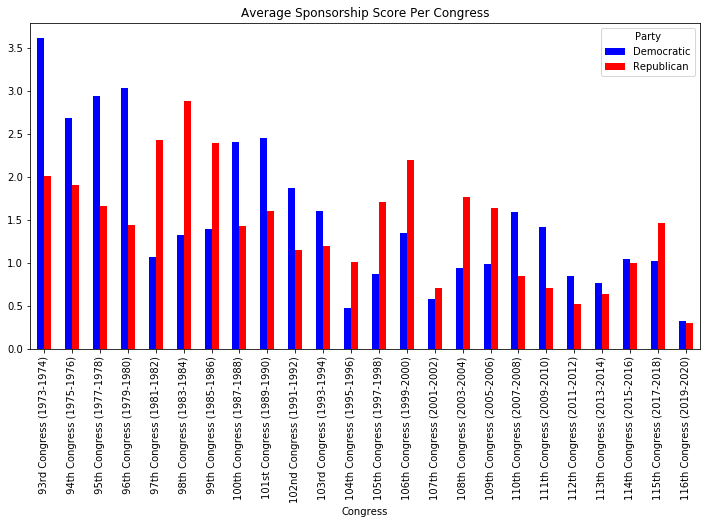

In [551]:
score_by_congress\
    .loc[['Republican', 'Democratic']]\
    .join(congress_map.set_index('Congress Number'), on=['Congress Number'], how='left')\
    .pivot_table(index='Congress', columns='Party', values='Weighted Score').plot.bar(color=['blue', 'red'], title='Average Sponsorship Score Per Congress', figsize=(12,6))
plt.show()

In [518]:
congress_map

,Congress,Congress Number
0,116th Congress (2019-2020),116
33,115th Congress (2017-2018),115
174,114th Congress (2015-2016),114
284,113th Congress (2013-2014),113
361,112th Congress (2011-2012),112
440,111th Congress (2009-2010),111
560,110th Congress (2007-2008),110
702,109th Congress (2005-2006),109
853,108th Congress (2003-2004),108
1001,107th Congress (2001-2002),107
